**Problem Statement:**
Develop a model for predicting fraudulent transactions for a financial company and use insights from the model to develop an actionable plan.

**Import libraries and loading dataset**

In [58]:
#Import all necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import itertools
from collections import Counter
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [59]:
# Read the data
df = pd.read_csv(r'/content/Fraud.csv')
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0.0,0.0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0.0,0.0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0.0,0.0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0.0,0.0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0.0,0.0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0.0,0.0


**Data Cleaning**

In [60]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,1.711401e+06,1.711401e+06,1.711401e+06,1.711401e+06,1.711401e+06,1.711401e+06,1.711400e+06,1711400.0
mean,7.106479e+01,1.625309e+05,8.614766e+05,8.826918e+05,9.942582e+05,1.117316e+06,1.068131e-03,0.0
std,5.728620e+01,2.701433e+05,2.928206e+06,2.964424e+06,2.305767e+06,2.405575e+06,3.266483e-02,0.0
min,1.000000e+00,6.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,1.800000e+01,1.314956e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
50%,4.100000e+01,7.895635e+04,1.515900e+04,0.000000e+00,1.359791e+05,2.280228e+05,0.000000e+00,0.0
75%,1.350000e+02,2.184767e+05,1.236960e+05,1.663356e+05,9.447242e+05,1.156991e+06,0.000000e+00,0.0
max,1.600000e+02,1.000000e+07,3.893942e+07,3.894623e+07,4.220740e+07,4.220740e+07,1.000000e+00,0.0


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1711401 entries, 0 to 1711400
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         float64
 10  isFlaggedFraud  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 143.6+ MB


In [62]:
df.shape

(1711401, 11)

In [63]:
# Now let's check if there are any null values present in data or not.
df = df.dropna()
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [64]:
legit = len(df[df.isFraud == 0])
fraud = len(df[df.isFraud == 1])
legit_percent = (legit / (fraud + legit)) * 100
fraud_percent = (fraud / (fraud + legit)) * 100

print("Number of Legit transactions: ", legit)
print("Number of Fraud transactions: ", fraud)
print("Percentage of Legit transactions: {:.4f} %".format(legit_percent))
print("Percentage of Fraud transactions: {:.4f} %".format(fraud_percent))

Number of Legit transactions:  1709572
Number of Fraud transactions:  1828
Percentage of Legit transactions: 99.8932 %
Percentage of Fraud transactions: 0.1068 %


In [65]:
# Merchants
X = df[df['nameDest'].str.contains('M')]
X.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0
5,1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0.0,0.0
6,1,PAYMENT,7107.77,C154988899,183195.0,176087.23,M408069119,0.0,0.0,0.0,0.0


**Correlation**

<ipython-input-66-b43972a5c17a>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr=df.corr()


<Axes: >

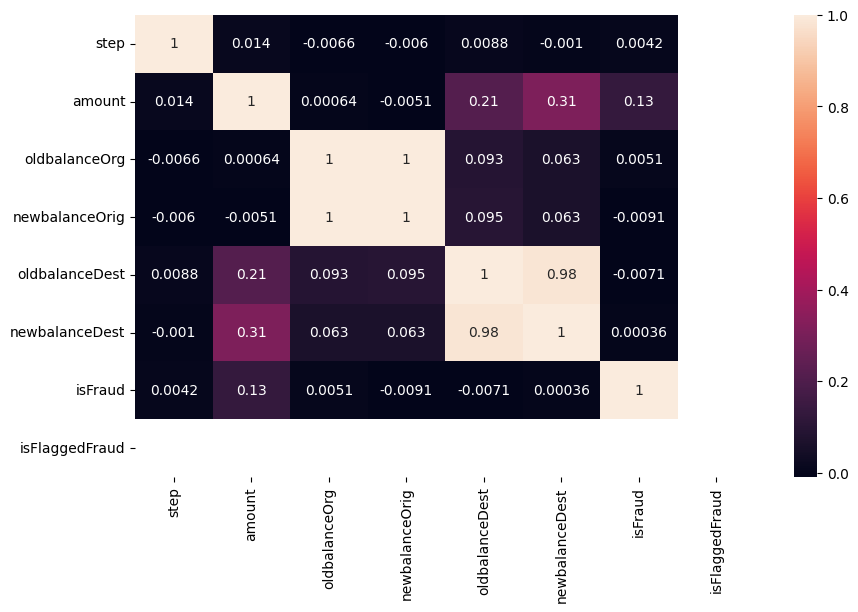

In [66]:
corr=df.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True)


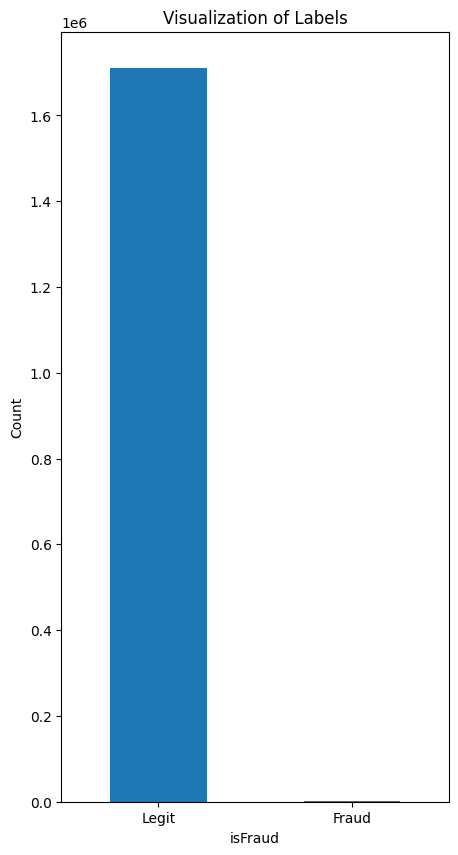

In [67]:
plt.figure(figsize=(5,10))
labels = ["Legit", "Fraud"]
count_classes = df.value_counts(df['isFraud'], sort= True)
count_classes.plot(kind = "bar", rot = 0)
plt.title("Visualization of Labels")
plt.ylabel("Count")
plt.xticks(range(2), labels)
plt.show()

In [68]:
#creating a copy of original dataset to train and test models

new_df=df.copy()
new_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


**Label Encoding**

In [69]:
# Checking how many attributes are dtype: object

objList = new_df.select_dtypes(include = "object").columns
print (objList)


Index(['type', 'nameOrig', 'nameDest'], dtype='object')


In [70]:
#Label Encoding for object to numeric conversion
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feat in objList:
    new_df[feat] = le.fit_transform(new_df[feat].astype(str))

print (new_df.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1711400 entries, 0 to 1711399
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int64  
 2   amount          float64
 3   nameOrig        int64  
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        int64  
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         float64
 10  isFlaggedFraud  float64
dtypes: float64(7), int64(4)
memory usage: 156.7 MB
None


In [71]:
new_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,204284,170136.0,160296.36,445339,0.0,0.0,0.0,0.0
1,1,3,1864.28,589911,21249.0,19384.72,464469,0.0,0.0,0.0,0.0
2,1,4,181.00,269833,181.0,0.00,120259,0.0,0.0,1.0,0.0
3,1,1,181.00,1569441,181.0,0.00,107197,21182.0,0.0,1.0,0.0
4,1,3,11668.14,927986,41554.0,29885.86,224592,0.0,0.0,0.0,0.0


**Multi-Colinearity**

In [72]:
# Import library for VIF (VARIANCE INFLATION FACTOR)

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(df):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return(vif)

calc_vif(new_df)


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1754: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,variables,VIF
0,step,2.119839
1,type,4.962393
2,amount,2.296756
3,nameOrig,2.673669
4,oldbalanceOrg,696.932913
5,newbalanceOrig,704.634266
6,nameDest,3.818759
7,oldbalanceDest,53.886988
8,newbalanceDest,57.880219
9,isFraud,1.149414


In [73]:
new_df['Actual_amount_orig'] = new_df.apply(lambda x: x['oldbalanceOrg'] - x['newbalanceOrig'],axis=1)
new_df['Actual_amount_dest'] = new_df.apply(lambda x: x['oldbalanceDest'] - x['newbalanceDest'],axis=1)
new_df['TransactionPath'] = new_df.apply(lambda x: x['nameOrig'] + x['nameDest'],axis=1)

#Dropping columns
new_df = new_df.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','step','nameOrig','nameDest'],axis=1)

calc_vif(new_df)


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1754: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,variables,VIF
0,type,2.762160
1,amount,1.907052
2,isFraud,1.143620
3,isFlaggedFraud,NaN
4,Actual_amount_orig,1.328017
5,Actual_amount_dest,1.746120
6,TransactionPath,2.718860


<Axes: >

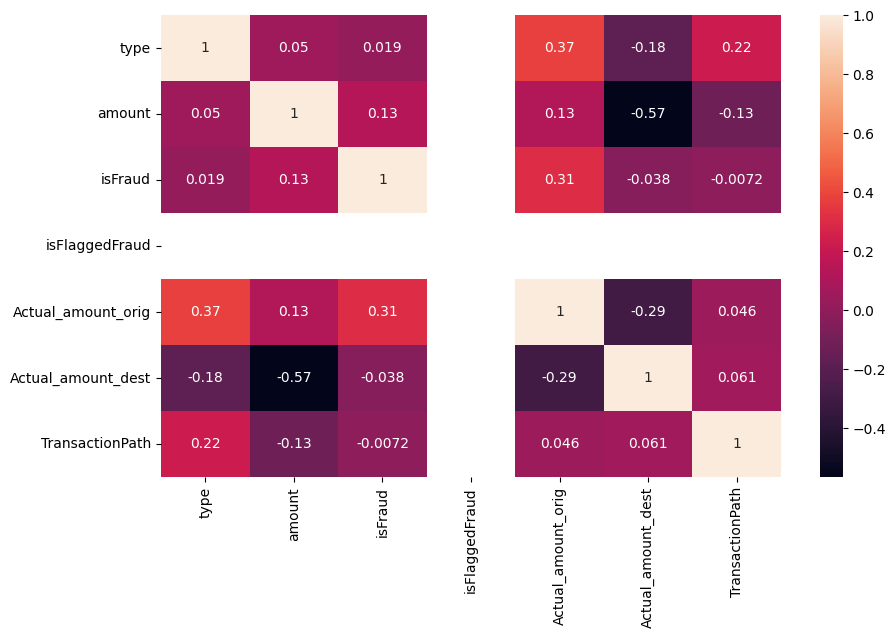

In [74]:
corr=new_df.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True)


**Normalizing (scaling) amount**

In [75]:
# Perform Scaling
scaler = StandardScaler()
new_df["NormalizedAmount"] = scaler.fit_transform(new_df["amount"].values.reshape(-1, 1))
new_df.drop(["amount"], inplace= True, axis= 1)

Y = new_df["isFraud"]
X = new_df.drop(["isFraud"], axis= 1)


**Training the data**

In [76]:
# Split the data
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size= 0.3, random_state= 42)

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (1197980, 6)
Shape of X_test:  (513420, 6)


**Data Modeling**

In [77]:
# DECISION TREE

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)

Y_pred_dt = decision_tree.predict(X_test)
decision_tree_score = decision_tree.score(X_test, Y_test) * 100


In [79]:
# RANDOM FOREST

random_forest = RandomForestClassifier(n_estimators= 100)
random_forest.fit(X_train, Y_train)

Y_pred_rf = random_forest.predict(X_test)
random_forest_score = random_forest.score(X_test, Y_test) * 100


In [80]:
# Print scores of our classifiers

print("Decision Tree Score: ", decision_tree_score)
print("Random Forest Score: ", random_forest_score)


Decision Tree Score:  99.93338786958046
Random Forest Score:  99.96104553776635


In [81]:
# key terms of Confusion Matrix - DT

print("TP,FP,TN,FN - Decision Tree")
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_dt).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

print("----------------------------------------------------------------------------------------")

# key terms of Confusion Matrix - RF

print("TP,FP,TN,FN - Random Forest")
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_rf).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

TP,FP,TN,FN - Decision Tree
True Positives: 364
False Positives: 165
True Negatives: 512714
False Negatives: 177
----------------------------------------------------------------------------------------
TP,FP,TN,FN - Random Forest
True Positives: 360
False Positives: 19
True Negatives: 512860
False Negatives: 181


In [82]:
# confusion matrix - DT

confusion_matrix_dt = confusion_matrix(Y_test, Y_pred_dt.round())
print("Confusion Matrix - Decision Tree")
print(confusion_matrix_dt,)

print("----------------------------------------------------------------------------------------")

# confusion matrix - RF

confusion_matrix_rf = confusion_matrix(Y_test, Y_pred_rf.round())
print("Confusion Matrix - Random Forest")
print(confusion_matrix_rf)


Confusion Matrix - Decision Tree
[[512714    165]
 [   177    364]]
----------------------------------------------------------------------------------------
Confusion Matrix - Random Forest
[[512860     19]
 [   181    360]]


In [83]:
# confusion matrix - DT

confusion_matrix_dt = confusion_matrix(Y_test, Y_pred_dt.round())
print("Confusion Matrix - Decision Tree")
print(confusion_matrix_dt,)

print("----------------------------------------------------------------------------------------")

# confusion matrix - RF

confusion_matrix_rf = confusion_matrix(Y_test, Y_pred_rf.round())
print("Confusion Matrix - Random Forest")
print(confusion_matrix_rf)


Confusion Matrix - Decision Tree
[[512714    165]
 [   177    364]]
----------------------------------------------------------------------------------------
Confusion Matrix - Random Forest
[[512860     19]
 [   181    360]]


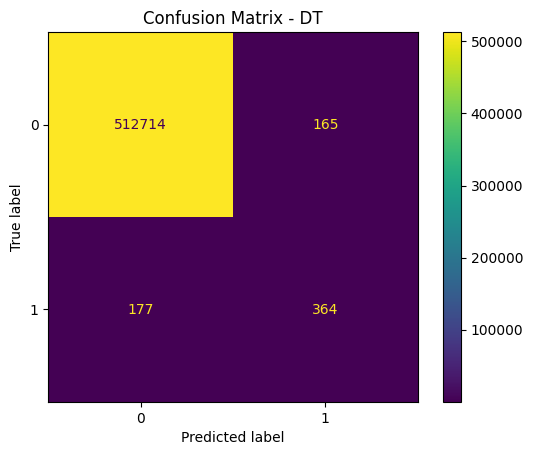

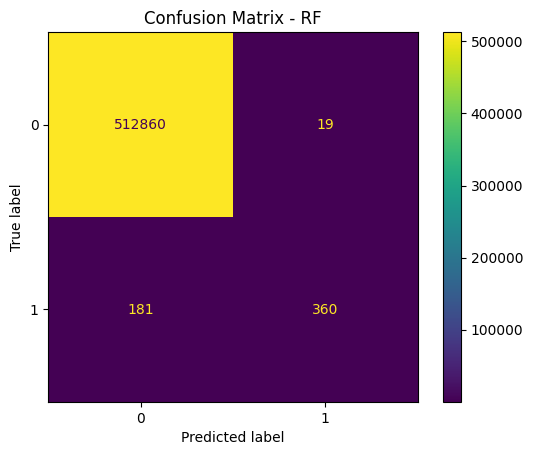

In [84]:
# visualising confusion matrix - DT


disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_dt)
disp.plot()
plt.title('Confusion Matrix - DT')
plt.show()

# visualising confusion matrix - RF
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_rf)
disp.plot()
plt.title('Confusion Matrix - RF')
plt.show()


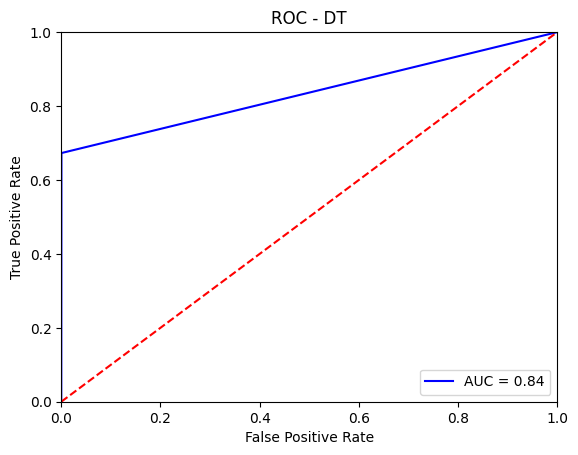

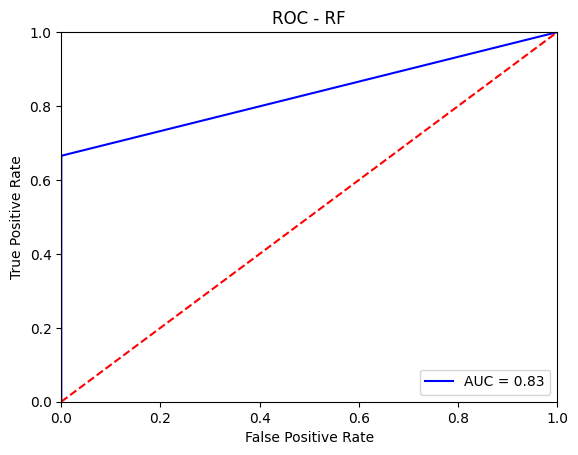

In [85]:
# AUC ROC - DT
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(Y_test, Y_pred_dt)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - DT')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# AUC ROC - RF
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(Y_test, Y_pred_rf)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - RF')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


**Conclusion**

We have seen that Accuracy of both Random Forest and Decision Tree is
equal, although teh precision of Random Forest is more. In a fraud
detection model, Precision is highly important because rather than
predicting normal transactions correctly we want Fraud transactions to
be predicted correctly and Legit to be left off.If either of the 2
reasons are not fulfiiled we may catch the innocent and leave the
culprit.
This is also one of the reason why Random Forest and Decision Tree are
used unstead of other algorithms.


Also the reason I have chosen this model is because of highly
unbalanced dataset (Legit: Fraud :: 99.87:0.13). Random forest makes
multiple decision trees which makes it easier (although time taking)
for model to understand the data in a simpler way since Decision Tree
makes decisions in a boolean way.


Models like XGBoost, Bagging, ANN, and Logistic Regression may give
good accuracy but they won't give good precision and recall values.

What are the key factors that predict fraudulent customer?

The source of request is secured or not ?
Is the name of organisation asking for money is legit or not ?
Transaction history of vendors.
What kind of prevention should be adopted while company update its
infrastructure?

Use smart vertified apps only.
Browse through secured websites.
Use secured internet connections (USE VPN).
Keep your mobile and laptop security updated.
Don't respond to unsolicited calls/SMS(s/E-mails.
If you feel like you have been tricked or security compromised,
contact your bank immidiately.
Assuming these actions have been implemented, how would you determine
if they work?

Bank sending E-statements.
Customers keeping a check of their account activity.
Always keep a log of your payments.